# SageMaker Neural Topic Model (NTM)

NTM performs unsupervised topic modelling, much like LDA, with the generative portion consisting of a deep neural network.

## Dependencies

In [ ]:
!pip install nltk
!pip install jsonlines

## Training data

First you'll need to download the [Open Research Corpus](https://labs.semanticscholar.org/corpus/), use as little or as much as you like. I've used the first chunk only and have pruned it to contain only papers from DBLP, so we have around 100,000 papers.

We start by extracting the titles and abstracts and build a topic vocabulary from the titles (only).

In [126]:
import jsonlines
import glob

from text_tokenizer import TextTokenizer

abstracts = []
titles = []

vocab_tf = {} # term frequency
tokenizer = TextTokenizer()

# very fast and simplistic filtering of German and French papers
def is_english(tokens):
    return not any(t in ['à', 'la', 'le', 'pour', 'für', 'die', 'zur'] for t in tokens)

for filename in glob.glob('dblp/s2-corpus-00'):
    print('processing', filename)
    with jsonlines.open(filename) as reader:
        for obj in reader:
            title = obj['title']
            abstract = obj['paperAbstract']
            if len(title) > 0:
                titles.append(title)
                tokens = tokenizer.run(title)
                if is_english(tokens):
                    for t in tokens:
                        if len(t)> 2:
                            if t in vocab_tf:
                                vocab_tf[t] += 1
                            else:
                                vocab_tf[t] = 0
            if len(abstract) > 0:
                tokens = tokenizer.run(abstract)
                if is_english(tokens):
                    abstracts.append(abstract)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
processing dblp/s2-corpus-00


In [127]:
import operator

# take the top 2000 terms
sorted_vocab = sorted(vocab_tf.items(), key=operator.itemgetter(1), reverse=True)
top_vocab = [t for t, c in sorted_vocab[:2000]]

## Vectorization

Tokenize, normalize and parse the abstracts into term vectors. We use the vocabulary extracted from the titles.

In [128]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from text_tokenizer import MultiWordTextTokenizer

vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = CountVectorizer(input='content', analyzer='word', vocabulary=top_vocab,
                             tokenizer=MultiWordTextTokenizer(), max_features=vocab_size)
vectors = vectorizer.fit_transform(abstracts)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
vocab size: 2000
Done. Time elapsed: 186.88s


In [129]:
# type-cast data to np.float32
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


## Upload to S3

In [130]:
import os
from sagemaker import get_execution_role

role = get_execution_role()

bucket = 'jahewson-neural-topics'
prefix = 'sagemaker/ntm/all_titles_ngrams'

train_prefix = os.path.join(prefix, 'train')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Trained model will be saved at', output_path)

train_vectors = vectors

Training set location s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train
Trained model will be saved at s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/output


In [131]:
# convert to RecordIO Protobuf and upload

def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0] // n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)

Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part0.pbr
Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part1.pbr
Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part2.pbr
Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part3.pbr
Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part4.pbr
Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part5.pbr
Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part6.pbr
Uploaded data to s3://jahewson-neural-topics/sagemaker/ntm/all_titles_ngrams/train/train_part7.pbr


## model training

In [144]:
import sagemaker
import boto3

container = '174872318107.dkr.ecr.us-west-2.amazonaws.com/ntm:latest'

sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=2,
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

In [145]:
# hyperparameters specific to NTM
num_topics = 10
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

In [146]:
# specify how the training data and validation data will be distributed to the workers during training
from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key') 

In [ ]:
# train!
ntm.fit({'train': s3_train})

In [148]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2019-03-20-22-34-39-376


## Inference with RecordIO Protobuf¶

## Model exploration

In [149]:
import mxnet as mx

In [150]:
model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
model_path

'sagemaker/ntm/all_titles_ngrams/output/ntm-2019-03-20-22-34-39-376/output/model.tar.gz'

In [151]:
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [152]:
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-2
model_algo-1


In [153]:
# use flag -o to overwrite previous unzipped content
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [154]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

In [155]:
!pip install wordcloud
import wordcloud as wc

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


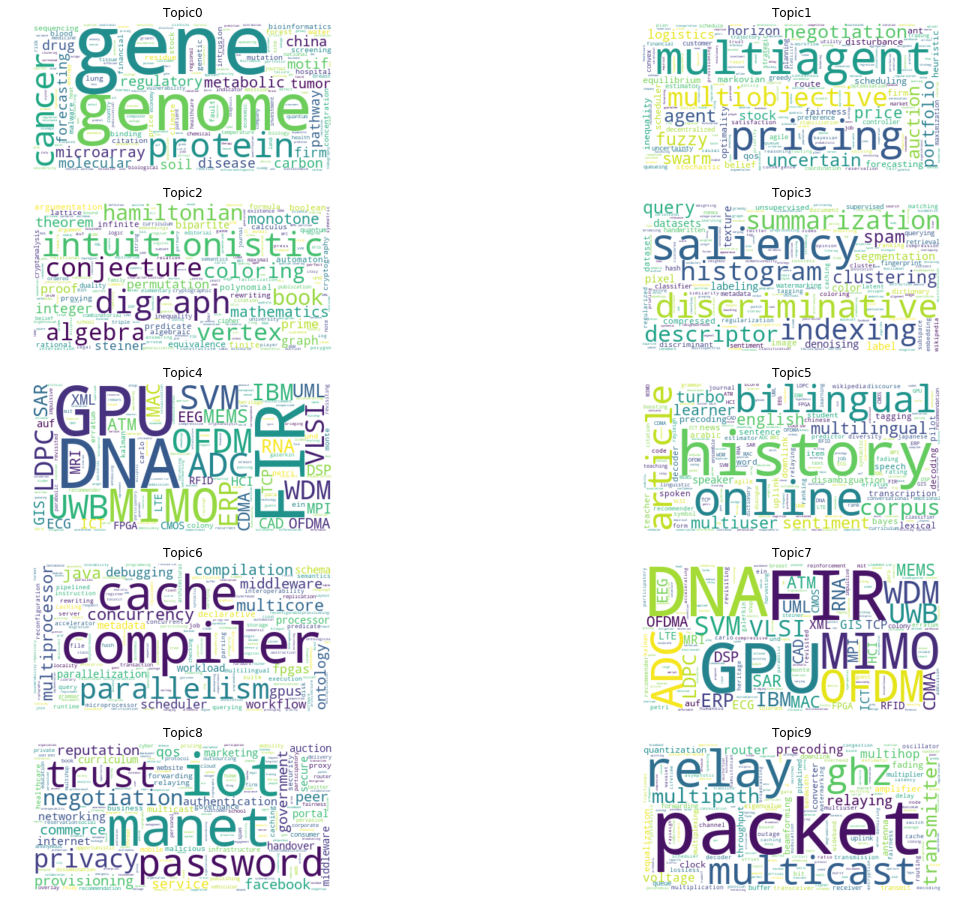

In [158]:
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 10
n_col = 2
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] = pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)

    counter +=1